# Práctica 2
## Pasos previos
Antes de comenzar las tareas, importamos todas las librerías necesarias para llevarlas a cabo.

In [11]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

## Primera tarea
En esta primera tarea aprovechamos el fragmento de código ya utilizado para realizar el conteo por columnas y lo adaptamos para realizar dicha cuenta también por filas.

0.341796875
0.3076171875


(0.0, 512.0)

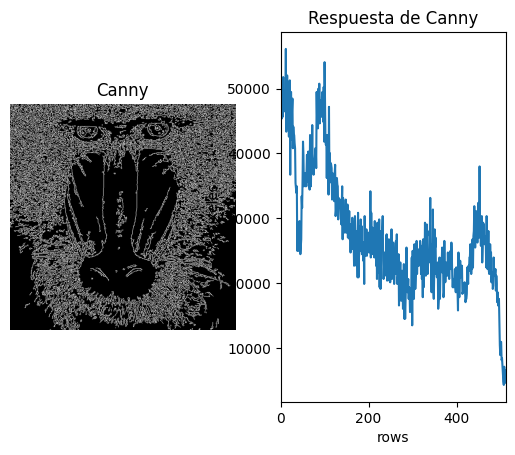

In [12]:
#El contenido de la imagen resultado de Canny, son valores 0 o 255, lo compruebas al descomentar
#print(canny)
#Cuenta el número de píxeles blancos (255) por columna
#Suma los valores de los pixeles por columna
img = cv2.imread('mandril.jpg')
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
canny = cv2.Canny(gris, 100, 200)
col_counts = cv2.reduce(canny, 0, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)
rows_count = cv2.reduce(canny,1,cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)
#Normaliza en base al número de filas, primer valor devuelto por shape, y al valor máximo del píxel (255)
#El resultado será el número de píxeles blancos por columna
cols = col_counts[0] / (255 * canny.shape[0])
rows = rows_count[0] / (255 * canny.shape[0]) #valor normalizado
max_row = rows.max() #valor mas grande
print(max_row)
max_row_limit = rows.max() *0.9
print(max_row_limit) #limite 
posible_rows = np.where(rows >= max_row_limit)[0] # valores que superan el humbral


#Muestra dicha cuenta gráficamente
plt.figure()
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Canny")
plt.imshow(canny, cmap='gray') 

#plt.subplot(1, 2, 2)
#plt.title("Respuesta de Canny")
#plt.xlabel("Columnas")
#plt.ylabel("% píxeles")
#plt.plot(cols)


# graficar las filas
plt.subplot(1, 2, 2)
plt.title("Respuesta de Canny")
plt.xlabel("rows")
plt.ylabel("% píxeles")
plt.plot(rows_count)





#Rango en x definido por las columnas
plt.xlim([0, canny.shape[1]])

## Segunda tarea
En esta segunda tarea, umbralizamos la imagen, realizamos la cuenta por filas y por columnas en sobel y buscamos el máximo por columnas y el máximo por filas. Tras esto, todos aquellos valores que sean superiores a 0.9 por el valor máximo de su fila o su columna serán representados por una línea, en este caso, verde para los valores superiores al máximo por fila y rojo para las columnas.

Máximo columnas: 391.0
Máximo filas: 391.0


(0.0, 256.0)

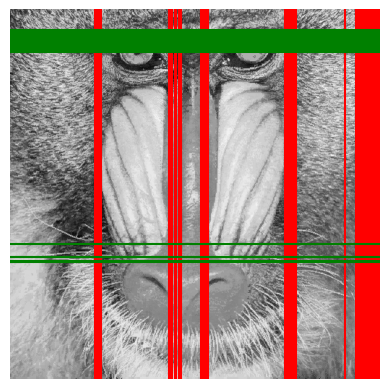

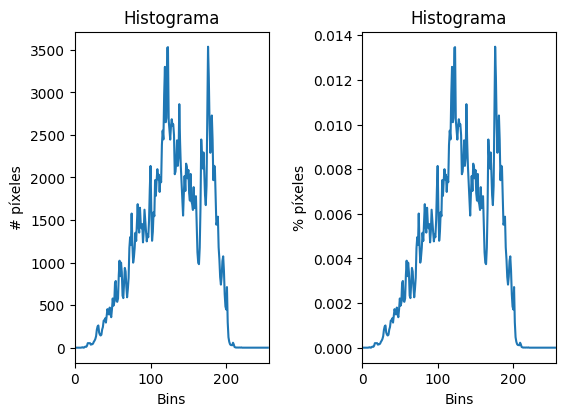

In [13]:
#Cálculo del histograma de una imagen en escala de grises
valorUmbral = 130 #Prueba otros valores
_, imagenUmbralizada = cv2.threshold(gris, valorUmbral, 255, cv2.THRESH_BINARY_INV)
hist = cv2.calcHist([gris], [0], None, [256], [0, 256])

rows_count_sobel = cv2.reduce(imagenUmbralizada,1,cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)
cols_count_sobel = cv2.reduce(imagenUmbralizada,0,cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)

cols_sobel = cols_count_sobel[0] / 255   # cuenta por columnas
rows_sobel = rows_count_sobel[:,0] / 255 # cuenta por filas

max_row = cols_sobel.max()
max_col = cols_sobel.max()

print("Máximo columnas:", max_col)
print("Máximo filas:", max_row)


plt.figure()
plt.axis("off")
plt.imshow(gris, cmap='gray')


for index, i in enumerate(cols_sobel):
    if i >= 0.90*max_col:
        plt.axvline(x=index, color='r') # rojo
          
for index, j in enumerate(rows_sobel):
    if j >= 0.90*max_row:
        plt.axhline(y=index, color='g') # verde
      
# Histograma sin normalizar
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Histograma")
plt.xlabel("Bins")
plt.ylabel("# píxeles")
plt.plot(hist)
plt.xlim([0, 256])

#Normaliza el histograma en base al número de píxeles y lo muestra
hist /= hist.sum()

plt.subplot(1, 2, 2)
plt.title("Histograma")
plt.xlabel("Bins")
plt.ylabel("% píxeles")
plt.tight_layout(pad=3.0) #separación entre plots
plt.plot(hist)
plt.xlim([0, 256])

## Tercera tarea
En este tercer apartado realizamos una demo interactiva sobre lo que hemos realizado durante las clases de la asignatura, permitiendo al usuario visualizar los diversos modos empleando teclas en su teclado, de forma que puede pasar del modo normal (simplemente la imagen de la webcam) a un pop art con 16 cuadrados, a un filtro con saturación por franjas sobre la imagen y a un modo en el que se resalta el píxel más oscuro y el más claro de la imagen. Para que el usuario sepa qué teclas debe usar, un mensaje es visible en la esquina inferior derecha de la ventana.

In [14]:
vid = cv2.VideoCapture(0)

sat_mode = False
pop_art_mode = False
circles_mode = False
mode = 0
w = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)) // 4
h = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT)) // 4

cols, rows = 4, 4
canvas_w, canvas_h = w * cols, h * rows
collage = np.zeros((canvas_h, canvas_w, 3), dtype=np.uint8)

# Definimos 16 combinaciones de (hue_shift, saturation_factor)
effects = []
for i in range(rows):
    for j in range(cols):
        hue_shift = (i * 60 + j * 20) % 180     # variamos el tono
        sat_factor = 0.5 + (i * cols + j) * 0.15  # variamos la saturación
        effects.append((hue_shift, sat_factor))
while(True):      
    # fotograma a fotograma
    ret, frame = vid.read()
    if ret:
        match mode:
            case 0:
                frame_to_show = frame
            case 1:
                b = frame[:,:,0]
                g = frame[:,:,1]
                r = frame[:,:,2]

                #modificacion comienzo del canal rojo
                # Guardamos copia del rojo original
                r_original = r.copy()

                r = 255 - r   # saturación automática en 255

                for i in range(0, r.shape[0], 40):  
                    r[i:i+10, :] = r_original[i:i+10, :]
                frame_to_show = cv2.merge((b, g, r))
            case 2:
                frame_to_show = frame
                gray = cv2.cvtColor(frame_to_show, cv2.COLOR_BGR2GRAY)

            # Encontramos el píxel más oscuro y más claro
                minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(gray)

                # Dibujamos círculos
                cv2.circle(frame_to_show, minLoc, 10, (255, 0, 0), 2)   # azul = más oscuro
                cv2.circle(frame_to_show, maxLoc, 10, (0, 255, 255), 2) # amarillo = más claro
            case 3:
                frame_small = cv2.resize(frame, (w, h), interpolation=cv2.INTER_AREA)

                idx = 0
                for i in range(rows):
                    for j in range(cols):
                        hue_shift, sat_factor = effects[idx]
                        idx += 1

                        # Convertimos a HSV
                        hsv = cv2.cvtColor(frame_small, cv2.COLOR_BGR2HSV).astype(np.float32)

                        # Cambiamos el tono (Hue)
                        hsv[:,:,0] = (hsv[:,:,0] + hue_shift) % 180

                        # Ajustamos la saturación
                        hsv[:,:,1] = np.clip(hsv[:,:,1] * sat_factor, 0, 255)

                        # Convertimos de nuevo a BGR
                        tile = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)

                        # Colocamos en el collage
                        collage[i*h:(i+1)*h, j*w:(j+1)*w] = tile

                # Dibujar borde general
                cv2.rectangle(collage, (0,0), (canvas_w-1, canvas_h-1), (0,0,0), 6)
                frame_to_show = collage
        cv2.putText(frame_to_show, "Tecla N para modo circulos en pixel mas claro y mas oscuro", (325,455), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0,0,0), 1, cv2.FILLED)
        cv2.putText(frame_to_show, "Tecla B para modo pop art", (325,465), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0,0,0), 1, cv2.FILLED)
        cv2.putText(frame_to_show, "Tecla M para modo saturacion", (325,475), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0,0,0), 1, cv2.FILLED)
        cv2.imshow('Webcam', frame_to_show)
    key = cv2.waitKey(20)
    if key == 27:
        break
    if key & 0xFF == ord('m'):
        mode = 1 if mode != 1 else 0
    if key & 0xFF == ord('n'):
        mode = 2 if mode != 2 else 0
    if key & 0xFF == ord('b'):
        mode = 3 if mode != 3 else 0
    
  
# Libera el objeto de captura
vid.release()
# Destruye ventanas
cv2.destroyAllWindows()

## Tarea 4
Finalmente, como propuesta hemos decidido implementar un detector de movimiento que divide la pantalla en 4 cuadrantes del mismo tamaño, dividiendo la imagen de la cámara tanto vertical como horizontalmente, y calcula la diferencia de movimiento de un fotograma al siguiente para detectar en cuál de los cuadrantes se ha detectado más movimiento, y resaltándolo en un color personalizado (azul para arriba-izquierda, verde para arriba-derecha, rojo para abajo-izquierda, amarillo para abajo-derecha).

In [15]:
vid = cv2.VideoCapture(0)

#Marca de inicio
disponible = 0 
while(True):      
    # fotograma a fotograma
    ret, frame = vid.read()

    if ret:
        left, right = np.hsplit(frame, 2)
        up_left, down_left = np.vsplit(left, 2)
        up_right, down_right = np.vsplit(right, 2)
        if disponible > 0:
            down_left_dif = cv2.absdiff(down_left, down_left_copy)
            down_right_dif = cv2.absdiff(down_right, down_right_copy)
            up_left_dif = cv2.absdiff(up_left, up_left_copy)
            up_right_dif = cv2.absdiff(up_right, up_right_copy)


            mean_down_left_dif = np.mean(down_left_dif)
            mean_down_right_dif = np.mean(down_right_dif)
            mean_up_left_dif = np.mean(up_left_dif)
            mean_up_right_dif = np.mean(up_right_dif)

            up_left_show = up_left.copy()
            up_right_show = up_right.copy()
            down_left_show = down_left.copy()
            down_right_show = down_right.copy()

            scores = {
            "up_left": mean_up_left_dif,
            "up_right": mean_up_right_dif,
            "down_left": mean_down_left_dif,
            "down_right": mean_down_right_dif
            }
            winner = max(scores, key=scores.get)
            if winner == "up_left":
                up_left_show[:, :, 0] = 255
            elif winner == "up_right":
                up_right_show[:, :, 1] = 255
            elif winner == "down_left":
                down_left_show[:, :, 2] = 255
            else:
                down_right_show[:, :, 2] = 255
                down_right_show[:, :, 1] = 255
            
            up_show   = cv2.hconcat([up_left_show, up_right_show])
            down_show = cv2.hconcat([down_left_show, down_right_show])
            final     = cv2.vconcat([up_show, down_show])
            final = cv2.flip(final, 1) # Damos vuelta para que coincida con las direcciones del usuario
            cv2.imshow('Diferencia', final)    
        else:
            disponible = 1

        
        down_left_copy = down_left.copy()
        down_right_copy = down_right.copy()
        up_left_copy = up_left.copy()
        up_right_copy = up_right.copy()
    # Detenemos pulsado ESC
    if cv2.waitKey(20) == 27:
        break
  
# Libera el objeto de captura
vid.release()
# Destruye ventanas
cv2.destroyAllWindows()